In [1]:
import library as l

import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import datetime
import os

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
file='aggressive_dedup.json'
size = 40000
topsize = 300

seed1 = np.random.randint(size)
print(seed1)
#seed2 = np.random.randint(size)
today = datetime.date.today()

savestring = 'seed_' + str(seed1) + '_size_' + str(size) + '_topsize_' + str(topsize) + '_date_' + str(today)

if not os.path.exists(savestring):
    os.makedirs(savestring)

15320


2001 >>> 40000 [0.19 0.81]
2002 >>> 40000 [0.2 0.8]
2003 >>> 40000 [0.22 0.78]
2004 >>> 40000 [0.23 0.77]
2005 >>> 40000 [0.25 0.75]
2006 >>> 40000 [0.23 0.77]
2007 >>> 40000 [0.21 0.79]
2008 >>> 40000 [0.22 0.78]
2009 >>> 40000 [0.23 0.77]
2010 >>> 40000 [0.24 0.76]
2011 >>> 40000 [0.25 0.75]
2012 >>> 40000 [0.22 0.78]
2013 >>> 40000 [0.21 0.79]
2014 >>> 40000 [0.21 0.79]
['2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014'] [641057, 665193, 721220, 862542, 1192688, 1298316, 1959168, 2251645, 2884651, 3796743, 6044654, 11471413, 28000200, 19699868]


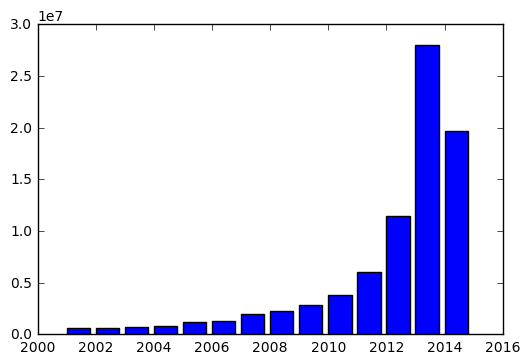

In [3]:
data, time, ratings, seen, indices = l.get_data(year='2001', size=size, limit=100000000)

l.save_file(savestring + '/indices.data', indices)
l.save_file(savestring + '/seen.data', seen)

l.simplify_ratings(data, ratings)
l.save_file(savestring + '/ratings.data', ratings)

#data2 = l.stopwords_filter(data)

l.selection_print(data, ratings)

x = sorted(list(data.keys()))
y = [seen.get(yr) for yr in x]
print(x, y)
plt.bar(x, y)
plt.show()
x = []
y = []

In [4]:
LR = LogisticRegression(penalty='l1', n_jobs=-1, solver='saga', max_iter=300)
#LR = LogisticRegression(penalty='l1', n_jobs=-1, solver='saga', max_iter=100, class_weight='balanced')

CV = CountVectorizer(ngram_range=(1,2), analyzer='word', min_df=5) #, max_features=20000)

features = []
x = sorted(list(data.keys()))

In [5]:
for i, key in enumerate(x):
    LR, CV = l.predict_scores(data[key], ratings[key], CV, LR, i, key, savestring, features)
    
    if i == 0:
        top_f = [[x,[len(features)-i]] for i, (_,x) in enumerate(sorted(zip(LR.coef_[0],features)))][:(-topsize - 1):-1]
        bot_f = [[x,[i+1]] for i, (_,x) in enumerate(sorted(zip(LR.coef_[0],features)))][:topsize]
    else:
        for j, m in enumerate(top_f):
            top_f[j][1] += [len(features)-k for k, (_,x) in enumerate(sorted(zip(LR.coef_[0],features))) if x == m[0]]
        for j, m in enumerate(bot_f):
            bot_f[j][1] += ([k+1 for k, (_,x) in enumerate(sorted(zip(LR.coef_[0],features))) if x == m[0]])

l.save_file(savestring + '/top_f.data', top_f)
l.save_file(savestring + '/bot_f.data', bot_f)

D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.8785
2001
f1: [0.61852433 0.92774309]
recall: [0.54195323 0.9532539 ]
precision: [0.7202925  0.90356212]

0.871875
2002
f1: [0.62713714 0.92264735]
recall: [0.54939452 0.95055201]
precision: [0.73050847 0.89633431]

0.87175
2003
f1: [0.67977528 0.91981869]
recall: [0.62228571 0.9416    ]
precision: [0.74896836 0.8990223 ]

0.854625
2004
f1: [0.64160247 0.90882007]
recall: [0.56978654 0.93892759]
precision: [0.73413258 0.88058341]

0.841625
2005
f1: [0.64158416 0.8983554 ]
recall: [0.56558603 0.93394495]
precision: [0.74117647 0.86537867]

0.8525
2006
f1: [0.63759214 0.90740741]
recall: [0.56321215 0.93909371]
precision: [0.73460722 0.87778959]

0.856
2007
f1: [0.60275862 0.91206107]
recall: [0.51807943 0.94630128]
precision: [0.72052762 0.88021217]

0.856625
2008
f1: [0.63107108 0.91102319]
recall: [0.55361174 0.94283879]
precision: [0.73373224 0.88128471]

0.841625
2009
f1: [0.60541887 0.90093049]
recall: [0.52286175 0.93812083]
precision: [0.71893491 0.86657641]

0.847125
2010
f1: 

In [6]:
for i in range(len(x)):
    print(sum([1/x[1][i] for x in top_f])/len(top_f))

0.020942212934331673
0.01770847241804565
0.0175352144227205
0.01780892024586639
0.0170200682153417
0.0171632213778515
0.01647481166453123
0.016585779501991197
0.015512027669876671
0.015265516946771591
0.014766352323715894
0.014030933905523207
0.014089781448036893
0.013750795459114578


In [7]:
for i in range(len(x)):
    print(sum([1/x[1][i] for x in bot_f])/len(bot_f))

0.020942212934331673
0.01752883331954784
0.017745645385502423
0.017914023163121854
0.017436922110608797
0.017589648347020034
0.016581526952957622
0.01712913257584442
0.015077814028492242
0.015077826662057682
0.01515534092336819
0.014083475327383722
0.01337676618565573
0.013167914539392384


In [8]:
len(bot_f)

300

In [9]:
for i, m in enumerate(top_f):
    for j, n in enumerate(top_f[i][1]):
        if n > 1000:
            top_f[i][1][j] = 1000

slope:  2.5164835164835164


D:\Programs\Anaconda\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


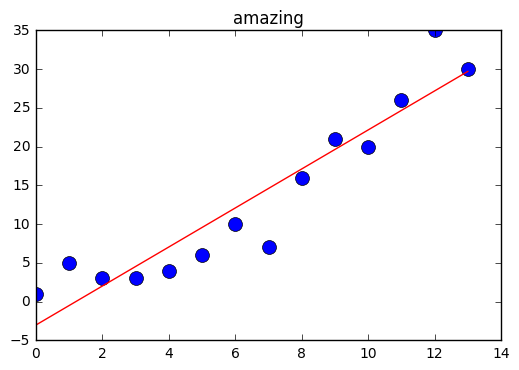

slope:  0.5362637362637361


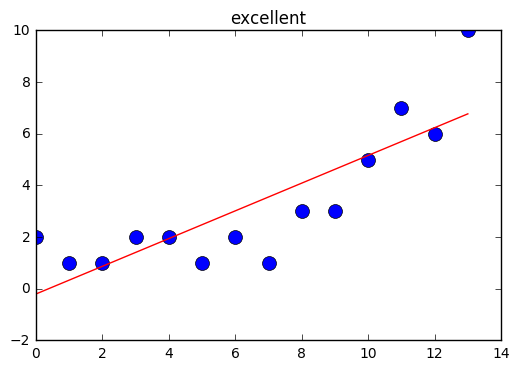

slope:  -0.2923076923076924


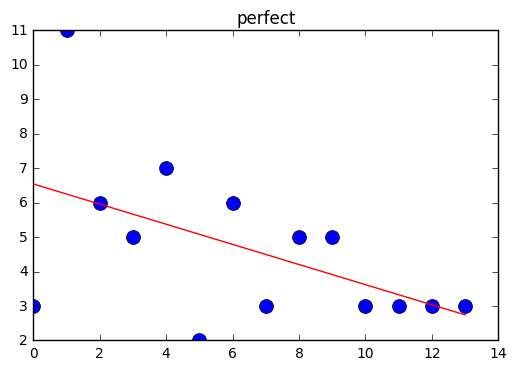

slope:  0.9736263736263735


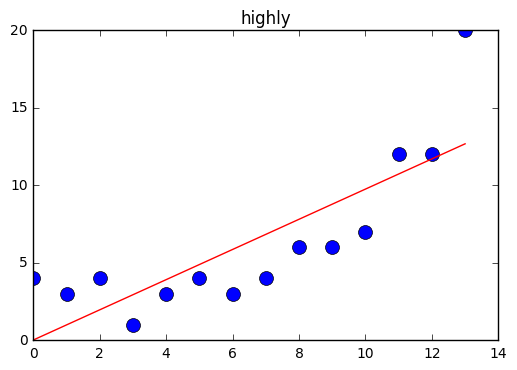

slope:  1.520879120879121


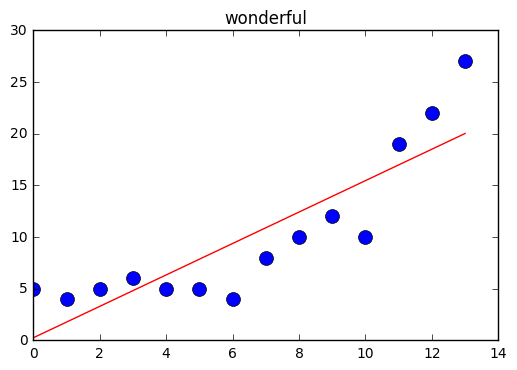

slope:  8.065934065934066


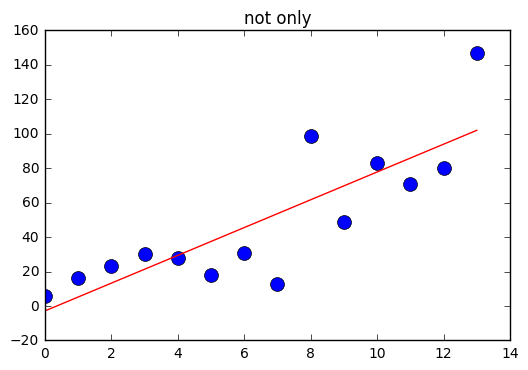

slope:  -0.4109890109890108


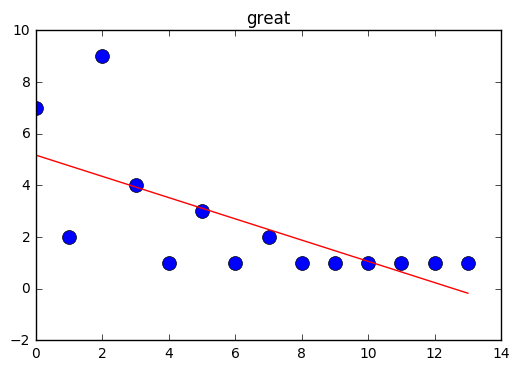

slope:  1.3824175824175824


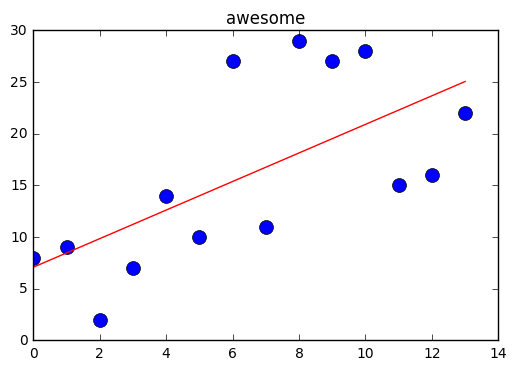

slope:  21.38241758241758


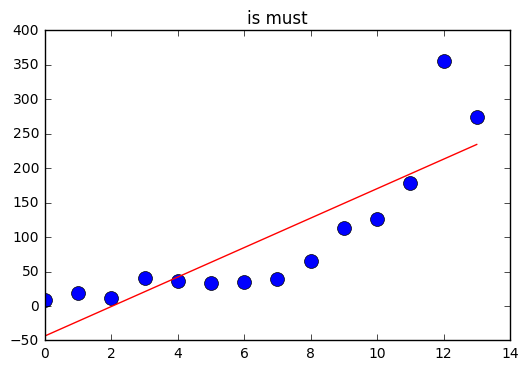

slope:  6.459340659340659


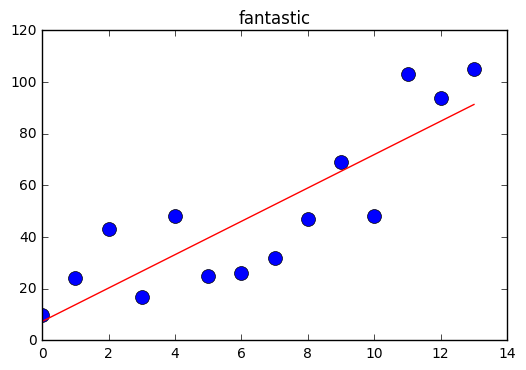

slope:  47.46813186813186


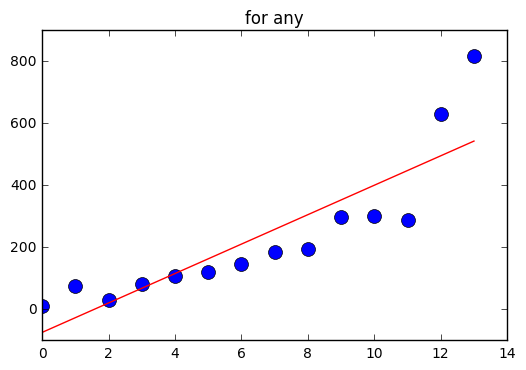

slope:  1.3340659340659338


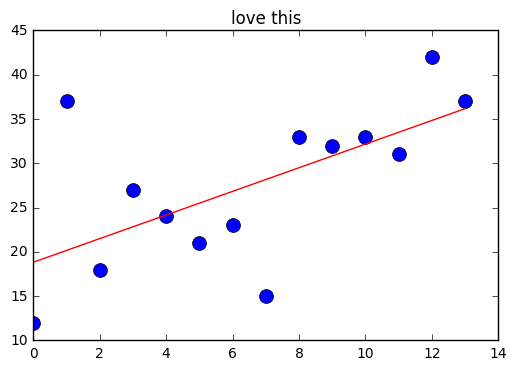

slope:  1.5494505494505495


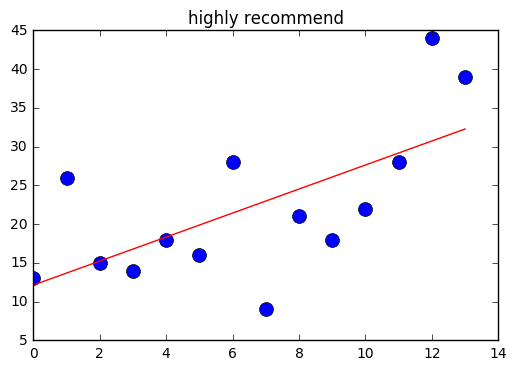

slope:  -2.2967032967032956


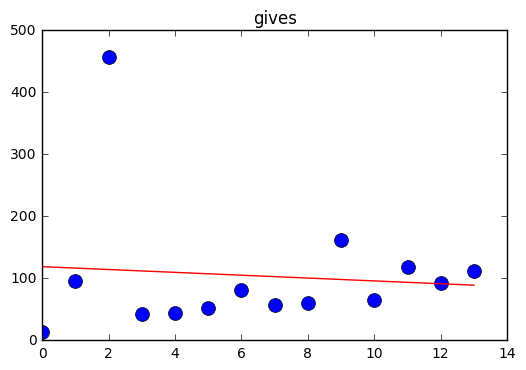

slope:  7.114285714285714


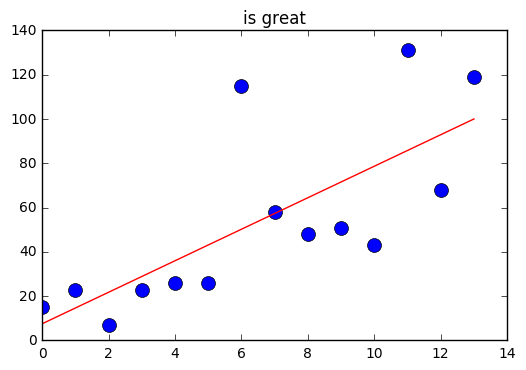

In [10]:
for i in range(15):
    temp = top_f[i][1]
    x = range(len(temp))
    y = temp
    A = np.vstack([x, np.ones(len(x))]).T
    m, c = np.linalg.lstsq(A, y)[0]
    print('slope: ', m)
    plt.plot(x, y, 'o', label='Original data', markersize=10)
    plt.plot(x, m*x + c, 'r', label='Fitted line')
    plt.title(top_f[i][0])
    plt.show()